In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

print(tf.config.list_physical_devices('GPU'))
from tensorflow.keras import layers, models, preprocessing

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip gdrive/MyDrive/pawpatrol/petfinder-pawpularity-score.zip

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  gdrive/MyDrive/pawpatrol/petfinder-pawpularity-score.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
url = 'https://raw.githubusercontent.com/Veer56/Pawl_patrol/main/Code/data/train.csv'
train_data = pd.read_csv(url, skipinitialspace = True)
train_data['Pawpularity'] = train_data['Pawpularity']
display(train_data.head(5))

train_data.isnull().values.any()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


False

In [ ]:
import os
import cv2
import numpy as np

def load_images_from_folder(folder, data = [], size=128):
    images = []
    labels = []
    names = []
    for filename in os.listdir(folder):
        name = filename.strip('.jpg')
        names.append(name)
        labels.append(data.loc[data['Id']== name]['Pawpularity'])
        img = cv2.resize(cv2.imread(os.path.join(folder,filename)), (size, size))
        if img is not None:
            images.append(img)
    return np.array(images), labels, names

image_images, image_labels, image_names = load_images_from_folder('train', data = train_data)

print(f'Training labels loaded: {image_images.shape}')

Training labels loaded: (9912, 128, 128, 3)


In [ ]:
Data = train_data.copy()
Data.Id = Data.Id.astype("category")

Data.Id.cat.set_categories(image_names, inplace=True)
Data = Data.sort_values(["Id"])

X = np.array(Data[['Subject Focus', 'Eyes', 'Face', 'Near', "Action", 'Accessory','Group', 'Collage','Human', 'Occlusion', 'Info', 'Blur']])

print(image_images.shape)
print(X.shape)
y = np.array(image_labels)
print(y.shape)
print(train_data['Subject Focus'])

(9912, 128, 128, 3)
(9912, 12)
(9912, 1)
0       0
1       0
2       0
3       0
4       0
       ..
9907    0
9908    0
9909    0
9910    0
9911    0
Name: Subject Focus, Length: 9912, dtype: int64


In [ ]:
def train_and_evaluate(model, input_img, input_tab, X_img, X_tab, y, preprocess={}, epochs=20, augment={}):

    model = tf.keras.Model(inputs=[input_img, input_tab], outputs = model)

    model.compile(loss=['mse'], optimizer='adam', metrics=['RootMeanSquaredError'])

    X_I_train, X_I_test, y_train, y_test, X_T_train, X_T_test = train_test_split(X_img, y, X_tab, test_size=0.33, random_state=42)

    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(X_I_train)     

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(X_I_test)    

    history = model.fit( train_gen.flow([X_I_train, X_T_train], y_train), epochs=epochs, 
                        validation_data = val_gen.flow([X_I_test, X_T_test], y_test), batch_size = 20, validation_batch_size = 20)

    fig, axs = plt.subplots(1, 2, figsize=(20, 5)) 

    for i, metric in enumerate(['loss', 'root_mean_squared_error']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_' + metric])
        axs[i].legend(['training', 'validation'], loc='best')
        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')
    
    plt.show()

    print(f"The validation root_mean_squared_error: {model.evaluate(val_gen.flow([X_I_test, X_T_test], y_test))[1]}")

Epoch 1/20
208/208 [==============================] - 26s 123ms/step - loss: 937.0333 - root_mean_squared_error: 30.6110 - val_loss: 771.8106 - val_root_mean_squared_error: 27.7815
Epoch 2/20
208/208 [==============================] - 26s 124ms/step - loss: 436.7446 - root_mean_squared_error: 20.8984 - val_loss: 463.5834 - val_root_mean_squared_error: 21.5310
Epoch 3/20
208/208 [==============================] - 26s 124ms/step - loss: 413.1029 - root_mean_squared_error: 20.3249 - val_loss: 582.4710 - val_root_mean_squared_error: 24.1344
Epoch 4/20
208/208 [==============================] - 26s 124ms/step - loss: 402.7290 - root_mean_squared_error: 20.0681 - val_loss: 594.7408 - val_root_mean_squared_error: 24.3873
Epoch 5/20
208/208 [==============================] - 26s 124ms/step - loss: 380.4799 - root_mean_squared_error: 19.5059 - val_loss: 554.4626 - val_root_mean_squared_error: 23.5470
Epoch 6/20
208/208 [==============================] - 26s 124ms/step - loss: 376.7841 - root_me

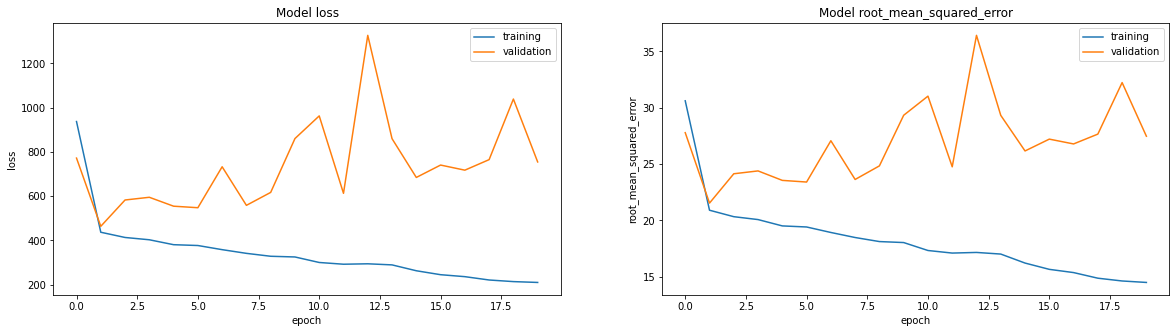

In [ ]:
model_img = tf.keras.Input(shape = image_images.shape[1:], name = 'IMG')
model_img_1 = tf.keras.layers.Conv2D(64,(3,3),activation='relu' ,padding='same', name = 'IMG_1')(model_img)
model_img_2 = tf.keras.layers.MaxPool2D((2,2), name = 'IMG_2')(model_img_1)
model_img_3 = tf.keras.layers.BatchNormalization(name = 'IMG_3')(model_img_2)

model_flatten = tf.keras.layers.Flatten(name = 'IMG_4')(model_img_3)
model_img_5 = tf.keras.layers.Dense(128,activation='relu', name = 'IMG_5')(model_flatten)


##### tabular
tabular = tf.keras.Input(shape = X.shape[1:], name = 'tabular') 
tabular1 = tf.keras.layers.Dense(52, activation='relu', name='tabular1')(tabular) 
tabular2 = tf.keras.layers.Dense((52*53) / 2 + 10, activation='relu', name='tabular2')(tabular1)
tabular3 = tf.keras.layers.Dense(50, activation='relu', name='tabular3')(tabular2)
tabular4 = tf.keras.layers.Dense(10, activation='relu', name='tabular4')(tabular3)

model_concat = tf.keras.layers.Concatenate(name = 'connection', axis = 1)([tabular4, model_img_5])
model = tf.keras.layers.Dense(1, activation = 'linear', name = 'finished' )(model_concat)


train_and_evaluate(model, model_img, tabular, image_images, X, y, preprocess = {'featurewise_center': True, 'featurewise_std_normalization' : True}, augment = {'vertical_flip' : True, 'zoom_range': 0.1, 'rotation_range' : 0.1})

In [ ]:
    test_images = []
    
    test_names = []
    for filename in os.listdir('test'):
        name = filename.strip('.jpg')
        test_names.append(name)
        img = cv2.imread(os.path.join('test',filename))
        if img is not None:
            test_images.append(img)

In [ ]:
test_images = np.array(test_images)
model.predict(test_images)

AttributeError: ignored

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 128)     

In [ ]:
X_img = np.arange(256).reshape(4,4,4,4)
preprocess, augment= {}, {}
train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
train_gen.fit(X_img) 

In [ ]:
print(train_gen)